### Libraries setup

In [ ]:
#!pip3 install -r requirements.txt
!pip3 install torchinfo numpy pandas nibabel torchio tqdm matplotlib SimpleITK scikit-learn

In [ ]:
#!unzip znorm_cropped_imgs.zip -d /storage

### 3D U-Net testing

In [ ]:
from models.unet3d import UNet
from torchinfo import summary

samp_unet = UNet(1)
summary(samp_unet, (2,1,40,56,72))
#summary(samp_unet, (1,1,196,196,196))

### Learning rate range test
As explained in this paper: https://arxiv.org/pdf/1506.01186.pdf

In [ ]:
import torchio as tio
from model_utils.train_eval import lr_range_plot, lr_range_test, lr_range_test_2d
from models.unet3d import UNet
from models.usegnet import SingleViewUSegNet
from data_utils.dataset import get_train_test_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

lr_test_unet = UNet(1)
lr_test_hist = lr_range_test(
    lr_test_unet,
    '/storage/znorm_cropped_imgs',
    'L',
    train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    end_lr=0.001,
    num_epochs=1
)

In [ ]:
lr_test_2dunet = SingleViewUSegNet()
lr_test_hist_2d = lr_range_test_2d(
    lr_test_2dunet,
    0,
    '/storage/znorm_cropped_imgs',
    'L',
    train_subj,
    batch_size=2,
    end_lr=0.01,
    num_epochs=1
)

In [ ]:
lr_range_plot(lr_test_hist, 'metric')

In [ ]:
lr_range_plot(lr_test_hist_2d, 'metric')

### 3D U-Net Train + Test

In [ ]:
import torchio as tio
import torch
from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

finalUNet = UNet(1)
finalUNet.load_state_dict(torch.load('final_3D_L.pth'))
finalUNet.to('cuda')
# train_history = train_model(
#     model=finalUNet,
#     dir_name='/storage/znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     transforms=[
#         tio.RandomNoise(),
#         tio.OneOf({
#             tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
#             tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
#         })
#     ],
#     batch_size=2,
#     num_epochs=100,
#     max_learn_rate=0.005
# )

test_loss, test_met, _, _ = start_eval(finalUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 1, True)

In [ ]:
import numpy as np

np.savez('final_3D_L_trainhist.npz', **train_history)
save_model(finalUNet, save_path='final_3D_L.pth')

### 3D U-Net hold-out cross validation

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

tr_train_subj, tr_val_subj = split_train_subjects('/storage/harp_metadata.csv', train_subj, 18, 42)

secondUNet = UNet(1)
train_val_hist = hocv_train_model(
    model = secondUNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=tr_train_subj,
    val_ids=tr_val_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=200,
    max_learn_rate=0.006
)

test_loss, test_met = start_eval(secondUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

### 3D U-Net 5-fold Cross Validation (GRID)

In [ ]:
import numpy as np
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, skfcv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

trainval_hist_3d_L_b2_e50 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.005,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_3d_L_b2_e50.npz', **trainval_hist_3d_L_b2_e50)

In [ ]:
trainval_hist_3d_R_b2_e50 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='R',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.005,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_3d_R_b2_e50.npz', **trainval_hist_3d_R_b2_e50)

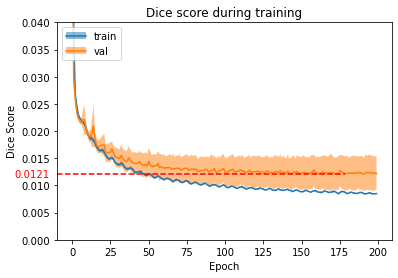

In [8]:
import numpy as np
from model_utils.metrics import plot_val_per_epoch

trainval_hist = np.load('saved_histories/3D_R/trainval_hist_3d_R_b2_e200.npz')
trainval_hist = dict(trainval_hist)

plot_val_per_epoch(trainval_hist,
                   [('train_loss_per_epoch', 'train'), ('val_loss_per_epoch', 'val')],
                  'Dice Score',
                  'Dice score during training',
                  (0.0, 0.04))

### 2D U-Net Train + Test

In [ ]:
import torchio as tio
import torch
from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import train_2d_model, hocv_train_model, start_2d_eval, save_model, start_ensemble_eval
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

sag_net = SingleViewUSegNet()
coro_net = SingleViewUSegNet()
axial_net = SingleViewUSegNet()
# Run these to skip training and load a pre-trained model
sag_net.load_state_dict(torch.load('final_2D_L0.pth'))
coro_net.load_state_dict(torch.load('final_2D_L1.pth'))
axial_net.load_state_dict(torch.load('final_2D_L2.pth'))
sag_net.to('cuda')
coro_net.to('cuda')
axial_net.to('cuda')
# sag_train_history = train_2d_model(
#     model=sag_net,
#     view=0,
#     dir_name='/storage/znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=4,
#     num_epochs=20,
#     max_learn_rate=0.009
# )
# coro_train_history = train_2d_model(
#     model=coro_net,
#     view=1,
#     dir_name='/storage/znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=2,
#     num_epochs=18,
#     max_learn_rate=0.008
# )

# axial_train_history = train_2d_model(
#     model=axial_net,
#     view=2,
#     dir_name='/storage/znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     batch_size=4,
#     num_epochs=22,
#     max_learn_rate=0.0085
# )

test_loss, test_met, test_precision, test_recall = start_2d_eval(sag_net, 0, '/storage/znorm_cropped_imgs', 'L', test_subj, 1, True)
test_loss, test_met, test_precision, test_recall = start_2d_eval(coro_net, 1, '/storage/znorm_cropped_imgs', 'L', test_subj, 1, True)
test_loss, test_met, test_precision, test_recall = start_2d_eval(axial_net, 2, '/storage/znorm_cropped_imgs', 'L', test_subj, 1, True)


In [ ]:
import numpy as np

np.savez('final_2D_L0_trainhist.npz', **train_history)
save_model(sag_net, save_path='final_2D_L0.pth')

In [ ]:
import torch
from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import start_ensemble_eval
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)


sag_net = SingleViewUSegNet()
coro_net = SingleViewUSegNet()
axial_net = SingleViewUSegNet()

sag_net.load_state_dict(torch.load('final_2D_L0.pth'))
coro_net.load_state_dict(torch.load('final_2D_L1.pth'))
axial_net.load_state_dict(torch.load('final_2D_L2.pth'))
sag_net.to('cuda')
coro_net.to('cuda')
axial_net.to('cuda')


mean_dice, mean_precision, mean_recall = start_ensemble_eval(
    model1=sag_net,
    model2=coro_net,
    model3=axial_net,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    test_ids=test_subj,
    batch_size=1,
    verbose=True
)

### 2D U-Net Holdout Cross Validation

In [ ]:
import torchio as tio

from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import train_2d_model, hocv_train_2d_model, start_2d_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

tr_train_subj, tr_val_subj = split_train_subjects('/storage/harp_metadata.csv', train_subj, 18, 42)

axial_net = SingleViewUSegNet()
train_val_hist = hocv_train_2d_model(
    model = axial_net,
    view=0,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=tr_train_subj,
    val_ids=tr_val_subj,
    batch_size=2,
    num_epochs=100,
    max_learn_rate=0.009
)

test_loss, test_met = start_2d_eval(axial_net, 0, '/storage/znorm_cropped_imgs', 'L', test_subj, verbose=True)

### 2D U-Net 5-fold Cross Validation

In [ ]:
import numpy as np
import torchio as tio

from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import train_2d_model, hocv_train_2d_model, skfcv_train_2d_model, start_2d_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

trainval_hist_2d_L0_b2_e50 = skfcv_train_2d_model(
    model_class = SingleViewUSegNet,
    view=0,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.009,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_2d_L0_b2_e50.npz', **trainval_hist_2d_L0_b2_e50)

In [ ]:
import numpy as np
from model_utils.metrics import plot_val_per_epoch

model_type='2d'
brain_side='L0'
batch_size=4
num_epoch=100

trainval_hist = np.load('saved_histories/{0}_{2}/trainval_hist_{1}_{2}_b{3}_e{4}.npz'.format(model_type.upper(), 
                                                                                     model_type,
                                                                                     brain_side,
                                                                                     batch_size,
                                                                                     num_epoch
                                                                                    ))
trainval_hist = dict(trainval_hist)

plot_val_per_epoch(trainval_hist,
                   [('train_loss_per_epoch', 'train'), ('val_loss_per_epoch', 'val')],
                  'BCE Loss',
                  'Loss during training (Batch size = {0})'.format(batch_size),
                  (0.0, 1))